# RAG vs TLX3 combined ChiP-seq RNA-seq analysis

## NB! Change RNA analysis to TLX3_vs_RAG using featureCounts

### From Nicolas about RAG replicate 2

"Hello,

Oui je n'ai fait qu'une seule réplicate pour RAG TLX3. 
Je n'avais pas assez de souris pour en faire une deuxième, 
et surtout que ces cellules n'expriment pas TLX3 normalement. 
Et je ne pense pas que quelqu'un à part moi ai fait RAG TLX3. 
Sinon les résultats donnent quoi?

Nico"

In [1]:
import numpy as np
import yaml
import os
from os.path import join 
import pybedtools as pb
import gffutils
from pybedtools.featurefuncs import TSS
from gffutils.helpers import asinterval
import matplotlib.pyplot as plt
import metaseq
import pandas as pd

In [2]:
# make database from GTF
#~ db = gffutils.create_db("mouse.mm9.NCBIM37.67.ORIGINAL.gtf", "mouse.mm9.NCBIM37.67.ORIGINAL.gtf.db")

In [3]:
ref_dir = '../../references/mm9'
data_dir = 'tracks'
rel_path = "/home/sergio/media"

In [4]:
#db = gffutils.FeatureDB(join(ref_dir,'mm9.gtf.db'))

In [5]:
file_t = open(join(data_dir,"TLX3_TLX3_list.yaml"), "r")
file_r = open(join(data_dir,"RAG_TLX3_list.yaml"), "r")

tlx_lst = yaml.load(file_t)
rag_lst = yaml.load(file_r)

In [6]:
def tss_generator():
    """
    Generator function to yield TSS of each annotated transcript
    """
    for transcript in db.features_of_type('transcript'):
        yield TSS(asinterval(transcript), upstream=1, downstream=0)

In [7]:
# A BedTool made out of a generator, and saved to file.
#tsses = pb.BedTool(tss_generator()).saveas(join(ref_dir,'mm9_tsses.gtf'))
tsses = pb.BedTool(join(ref_dir,'mm9_tsses.gtf'))

#Let's use pybedtools to add 1kb to either side of the TSS. This uses the BEDTools slop 
#routine; see the docs for that program for how to make changes to up/downstream distances.
#tsses_1kb = tsses.slop(b=1000, genome='mm9', output=join(ref_dir,'mm9_tsses-1kb.gtf'))
#tsses_2kb = tsses.slop(b=2000, genome='mm9', output=join(ref_dir,'mm9_tsses-2kb.gtf'))
#tsses_3kb = tsses.slop(b=3000, genome='mm9', output=join(ref_dir,'mm9_tsses-3kb.gtf'))
#tsses_5kb = tsses.slop(b=5000, genome='mm9', output=join(ref_dir,'mm9_tsses-5kb.gtf'))

In [8]:
tsses_1kb = pb.BedTool(join(ref_dir,'mm9_tsses-1kb.gtf'))
tsses_5kb = pb.BedTool(join(ref_dir,'mm9_tsses-5kb.gtf'))

In [9]:
# ---------------------------------------------------------
#~ Metaseq #
# ---------------------------------------------------------

#~ metaseq works with the concepts of signal and windows. In this example, the signal is ChIP data, 
#and the windows are TSS +/- 1kb.

#~ The first step is to create "genomic signal" objects out of the data. Since our example 
#files are BAM files, we specify the kind='bam', but if you have your own data 
#in a different format (bigWig, bigBed, BED, GFF, GTF, VCF) then specify that 
#format instead (see metaseq.genomic_signal()).

In [10]:
# ChiP-seq signals 
tlx_bam = rel_path+tlx_lst["tracks"][0]
tlx_inp = rel_path+tlx_lst["input"][0]
rag_bam = rel_path+rag_lst["tracks"][0]
rag_inp = rel_path+rag_lst["input"][0]

tlx_bw = rel_path+tlx_lst["tracks"][2]
rag_bw = rel_path+rag_lst["tracks"][2]

# RNA-seq expression tables
tlx_tabf = rel_path+tlx_lst["table"][0]
rag_tabf = rel_path+rag_lst["table"][0]
tlx_tabff = rel_path+tlx_lst["table"][3]
rag_tabff = rel_path+rag_lst["table"][3]
rag_vs_tlx_tabf = "tracks/RAG_VS_TLX3_DEG_By_edgeR.txt"

In [11]:
#print tlx_bam
#print tlx_inp
#print rag_bam
#print rag_inp
#print tlx_tabf
#print rag_tabf
print tlx_tabff
print rag_tabff

/home/sergio/media/NAS3B/Bioinfoplatform/PFlab/RNA-Seq/RNA-SEQ_ANALYSIS/31-featureCounts/TLX3_featureCounts.txt
/home/sergio/media/NAS3B/Bioinfoplatform/PFlab/RNA-Seq/RNA-SEQ_ANALYSIS/31-featureCounts/RAG_featureCounts.txt


In [12]:
tlx_sig_bw = metaseq.genomic_signal(tlx_bw,'bigwig')
rag_sig_bw = metaseq.genomic_signal(rag_bw,'bigwig')
#tlx_signal = metaseq.genomic_signal(tlx_bam,'bam')
#tlx_input = metaseq.genomic_signal(tlx_inp,'bam')

#rag_signal = metaseq.genomic_signal(rag_bam,'bam')
#rag_input = metaseq.genomic_signal(rag_inp,'bam')

In [13]:
import multiprocessing
processes = multiprocessing.cpu_count()

if  not os.path.exists('tlx-vs-rag_tlx3.npz'):
    tlx_bw_arr = tlx_sig_bw.array(tsses_1kb, bins=100, processes=processes)
    rag_bw_arr = rag_sig_bw.array(tsses_1kb, bins=100, processes=processes)
    
    #tlx_sig_arr = tlx_signal.array(tsses_1kb, bins=100, processes=processes)
    #tlx_inp_arr = tlx_input.array(tsses_1kb, bins=100, processes=processes)

    #rag_sig_arr = rag_signal.array(tsses_1kb, bins=100, processes=processes)
    #rag_inp_arr = rag_input.array(tsses_1kb, bins=100, processes=processes)
    # Normalize to library size. The values in the array
        # will be in units of "reads per million mapped reads"
    #tlx_sig_arr /= tlx_signal.mapped_read_count() / 1e6
    #tlx_inp_arr /= tlx_input.mapped_read_count() / 1e6
    #rag_sig_arr /= rag_signal.mapped_read_count() / 1e6
    #rag_inp_arr /= rag_input.mapped_read_count() / 1e6
    
    # Cache to disk. The data will be saved as "example.npz" and "example.features".
       # arrays={'tlx-bw': tlx_bw_arr,'tlx-sig': tlx_sig_arr, 'tlx-inp': tlx_inp_arr, 
       #         'rag-bw': rag_bw_arr,'rag-sig': rag_sig_arr, 'rag-inp': rag_inp_arr}
    metaseq.persistence.save_features_and_arrays(
            features=tsses,
            arrays={'tlx-bw': tlx_bw_arr, 
                    'rag-bw': rag_bw_arr},
            prefix='tlx-vs-rag_tlx3',
            link_features=False,
            overwrite=True)

In [14]:
if  not os.path.exists('tlx-vs-rag_tlx3_5Kb.npz'):
    tlx_bw_arr = tlx_sig_bw.array(tsses_5kb, bins=100, processes=processes)
    rag_bw_arr = rag_sig_bw.array(tsses_5kb, bins=100, processes=processes)
    
    
    # Cache to disk. The data will be saved as "example.npz" and "example.features".
    metaseq.persistence.save_features_and_arrays(
            features=tsses,
            arrays={'tlx-bw': tlx_bw_arr,
                    'rag-bw': rag_bw_arr},
            prefix='tlx-vs-rag_tlx3_5Kb',
            link_features=False,
            overwrite=True)

In [15]:
#print tlx_signal.mapped_read_count()
#print tlx_input.mapped_read_count()
#print rag_signal.mapped_read_count()
#print rag_input.mapped_read_count()

In [16]:
features, arrays = metaseq.persistence.load_features_and_arrays(prefix='tlx-vs-rag_tlx3')

In [17]:
features5K, arrays5K = metaseq.persistence.load_features_and_arrays(prefix='tlx-vs-rag_tlx3_5Kb')

In [18]:
# This ought to be exactly the same as the number of features in `tsses_1kb.gtf`
assert len(features) == len(tsses_1kb) 

# This shows that `arrays` acts like a dictionary
#assert sorted(arrays.keys()) == ['rag', 'tlx']
print sorted(arrays.keys())

# This shows that the IP and input arrays have one row per feature, and one column per bin
#assert arrays['tlx'].shape == arrays['rag'].shape
print arrays['tlx-sig'].shape
print arrays['tlx-bw'].shape

['rag-bw', 'rag-inp', 'rag-sig', 'tlx-bw', 'tlx-inp', 'tlx-sig']
(97251, 100)
(97251, 100)


In [19]:
#print arrays['tlx'].shape
#print arrays['tlx'][50550:50650,50]


In [20]:
# ---------------------------------------------------------
#~ Line plot of average signal
# ---------------------------------------------------------

# Enable in-line plots for this example
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Tweak some font settings so the results look nicer
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

#tlx_norm_sub = arrays['tlx-sig'] - arrays['tlx-inp']
#rag_norm_sub = arrays['rag-sig'] - arrays['rag-inp']

#tlx_norm_sub = tlx_sig_arr - tlx_inp_arr
#rag_norm_sub = rag_sig_arr - rag_inp_arr

# TLX3 and RAG average signals around TSS

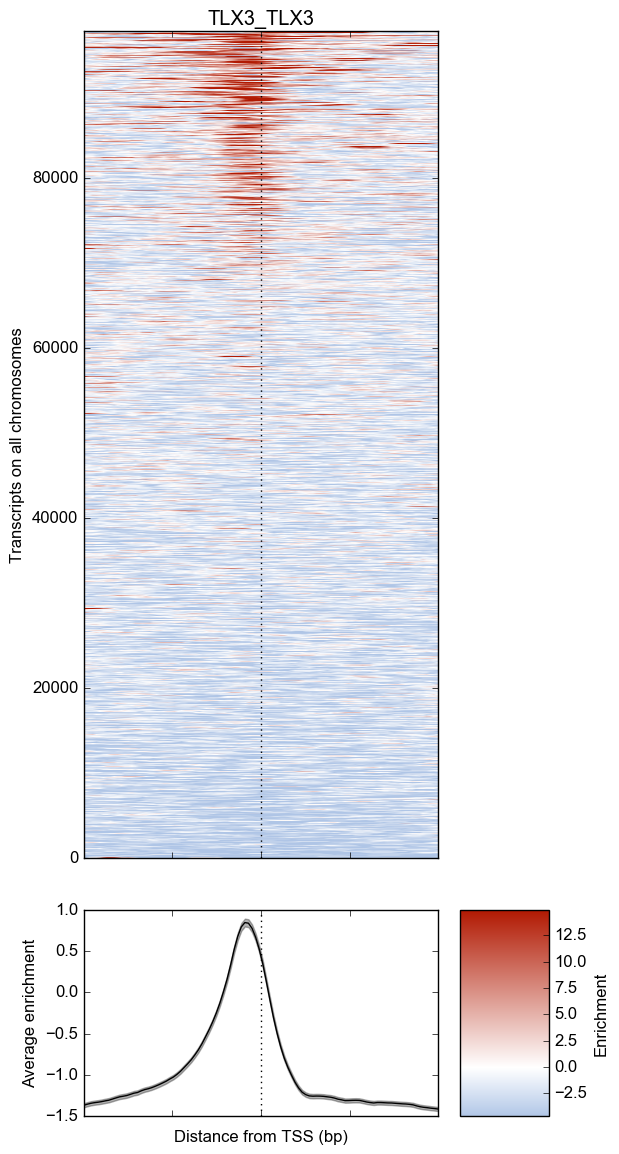

In [23]:
#~ Now that we have NumPy arrays of signal over windows, there’s a lot we can do. 
#~ One easy thing is to simply plot the mean signal of IP and of input. Let’s construct 
#~ meaningful values for the x-axis, from -1000 to +1000 over 100 bins. 
#~ We’ll do this with a NumPy array.

x = np.linspace(-1000, 1000, 100)

fig2 = metaseq.plotutils.imshow(
    arrays['tlx-bw'],
    x=x,
    figsize=(6, 14),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    sort_by=arrays['tlx-bw'].mean(axis=1)
)

#
fig2.line_axes.set_ylabel('Average enrichment');
fig2.line_axes.set_xlabel('Distance from TSS (bp)');
# "array_axes" is our handle for working on the upper array axes.
# Add a nicer axis label
fig2.array_axes.set_ylabel('Transcripts on all chromosomes')

# Remove the x tick labels, since they're redundant
# with the line axes
fig2.array_axes.set_xticklabels([])

# Add a vertical line to indicate zero in both the array axes
# and the line axes
fig2.array_axes.axvline(0, linestyle=':', color='k')
fig2.line_axes.axvline(0, linestyle=':', color='k')

fig2.cax.set_ylabel("Enrichment")
fig2.array_axes.set_title("TLX3_TLX3")

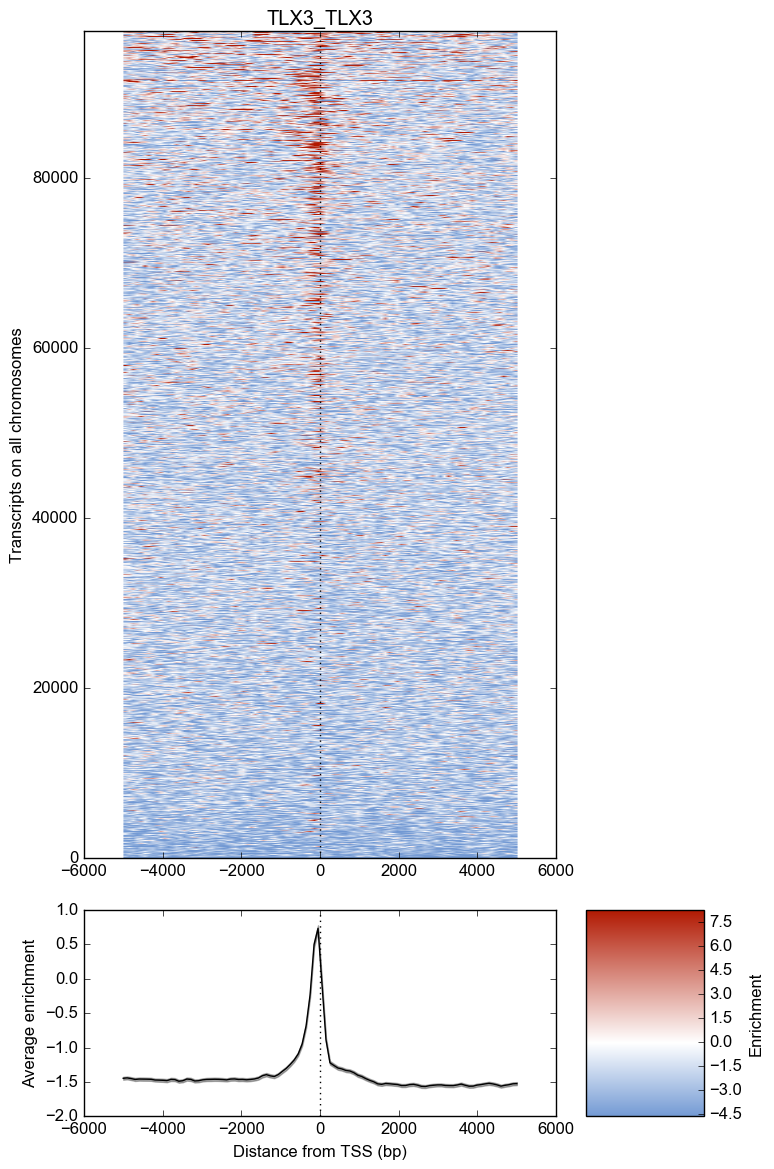

In [24]:
# 5K aroun TSS

xx = np.linspace(-5000, 5000, 100)
fig5 = metaseq.plotutils.imshow(
    arrays5K['tlx-bw'],
    x=xx,
    figsize=(8, 14),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    sort_by=arrays5K['tlx-bw'].mean(axis=1)
    #sort_by= np.argmax(arrays5K['tlx-bw'], axis=1)
)

# "line_axes" is our handle for working on the lower axes.
# Add some nicer labels.
fig5.line_axes.set_ylabel('Average enrichment');
fig5.line_axes.set_xlabel('Distance from TSS (bp)');
# "array_axes" is our handle for working on the upper array axes.
# Add a nicer axis label
fig5.array_axes.set_ylabel('Transcripts on all chromosomes')

# Remove the x tick labels, since they're redundant
# with the line axes
#fig1.array_axes.set_xticklabels([])

# Add a vertical line to indicate zero in both the array axes
# and the line axes
fig5.array_axes.axvline(0, linestyle=':', color='k')
fig5.line_axes.axvline(0, linestyle=':', color='k')

fig5.cax.set_ylabel("Enrichment")
fig5.array_axes.set_title("TLX3_TLX3")

# RAG_TLX3 signals around TSS sorted by mean signal of TLX3_TLX3

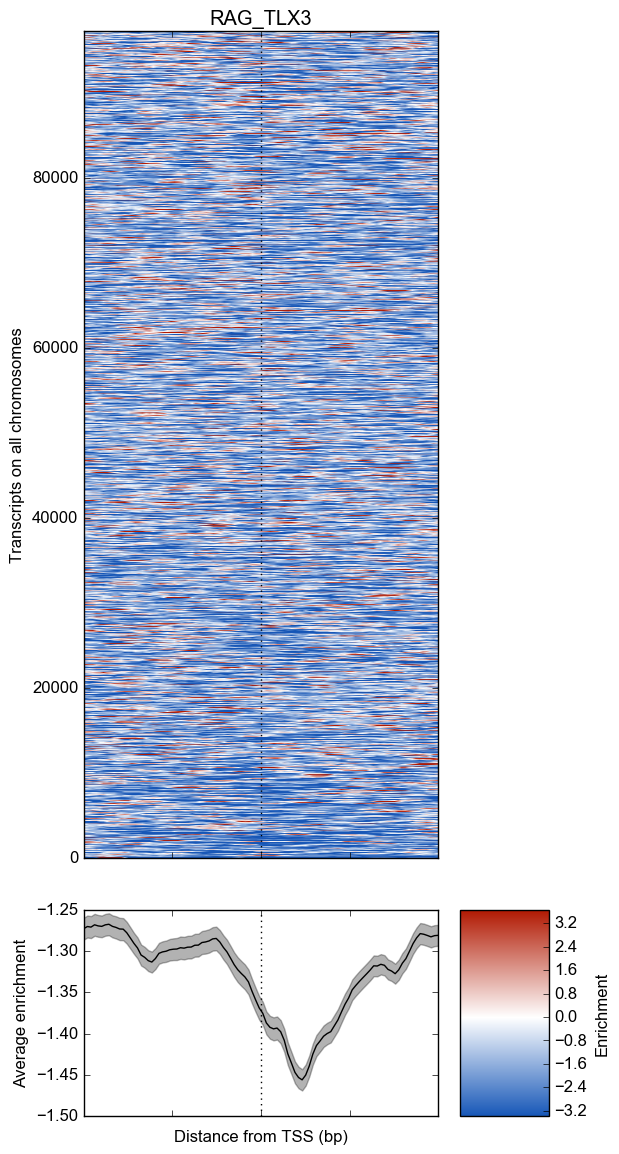

In [26]:
fig = metaseq.plotutils.imshow(
    arrays['rag-bw'],
    x=x,
    figsize=(6, 14),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    sort_by=arrays['tlx-bw'].mean(axis=1)
)
# "line_axes" is our handle for working on the lower axes.
# Add some nicer labels.
fig.line_axes.set_ylabel('Average enrichment');
fig.line_axes.set_xlabel('Distance from TSS (bp)');
# "array_axes" is our handle for working on the upper array axes.
# Add a nicer axis label
fig.array_axes.set_ylabel('Transcripts on all chromosomes')

# Remove the x tick labels, since they're redundant
# with the line axes
fig.array_axes.set_xticklabels([])

# Add a vertical line to indicate zero in both the array axes
# and the line axes
fig.array_axes.axvline(0, linestyle=':', color='k')
fig.line_axes.axvline(0, linestyle=':', color='k')

fig.cax.set_ylabel("Enrichment")
fig.array_axes.set_title("RAG_TLX3")

# RNA-seq data wrangling: aligning RNA-seq data with ChIP-seq data

In [27]:
from metaseq.results_table import ResultsTable, DESeq2Results

tlx_table = ResultsTable(tlx_tabf, import_kwargs=dict(index_col=0, names=['score']))
rag_table = ResultsTable(rag_tabf, import_kwargs=dict(index_col=0, names=['score']))
rag_vs_tlx_table = DESeq2Results(rag_vs_tlx_tabf, import_kwargs=dict(index_col=0))

tlx_fC_tb = ResultsTable(tlx_tabff, import_kwargs=dict(index_col=0, header=1))
rag_fC_tb = ResultsTable(rag_tabff, import_kwargs=dict(index_col=0, header=1))


In [28]:
tlx_table.data.head()
print len(rag_vs_tlx_table.data)
print len(rag_fC_tb.data)

13098
97251


In [29]:
# RPKM expression level calculation based on featureCounts tables
# TLX
print tlx_fC_tb.data.columns
tlx_fC_tb.data['TLX3'] = tlx_fC_tb.data['TLX3-1_1']+tlx_fC_tb.data['TLX3-1_5']+tlx_fC_tb.data['TLX3-1_P']
tlx_fC_tb.data['tlx_rpkm'] = (10e9 * tlx_fC_tb.data['TLX3'])/(tlx_fC_tb.data['TLX3'].sum() * tlx_fC_tb.data['Length']) 
tlx_fC_tb.data[['TLX3-1_1','TLX3-1_5','TLX3-1_P','TLX3', 'tlx_rpkm']].head(20)

Index([u'Chr', u'Start', u'End', u'Strand', u'Length', u'TLX3-1_1',
       u'TLX3-1_5', u'TLX3-1_P'],
      dtype='object')


,TLX3-1_1,TLX3-1_5,TLX3-1_P,TLX3,tlx_rpkm
Geneid,,,,,
ENSMUST00000027847,0,0,0,0,0.000000
ENSMUST00000060833,0,0,0,0,0.000000
ENSMUST00000166159,0,0,0,0,0.000000
ENSMUST00000166860,0,0,0,0,0.000000
ENSMUST00000000834,10,5,10,25,0.963102
ENSMUST00000074892,0,0,0,0,0.000000
ENSMUST00000001166,0,0,0,0,0.000000
ENSMUST00000097776,25,29,20,74,1.043456
ENSMUST00000135100,1,2,2,5,0.432336


In [30]:
# RAG
print rag_fC_tb.data.columns
rag_fC_tb.data['RAG'] = rag_fC_tb.data['R2-RAG1W-RAG1']+rag_fC_tb.data['RAGS-RAGZ']+rag_fC_tb.data['RAGZ']
rag_fC_tb.data['rag_rpkm'] = (10e9 * rag_fC_tb.data['RAG'])/(rag_fC_tb.data['RAG'].sum() * rag_fC_tb.data['Length']) 
rag_fC_tb.data[['R2-RAG1W-RAG1','RAGS-RAGZ','RAGZ','RAG', 'rag_rpkm']].head(20)

Index([u'Chr', u'Start', u'End', u'Strand', u'Length', u'R2-RAG1W-RAG1',
       u'RAGS-RAGZ', u'RAGZ'],
      dtype='object')


,R2-RAG1W-RAG1,RAGS-RAGZ,RAGZ,RAG,rag_rpkm
Geneid,,,,,
ENSMUST00000027847,0,0,0,0,0.000000
ENSMUST00000060833,0,0,0,0,0.000000
ENSMUST00000166159,0,0,0,0,0.000000
ENSMUST00000166860,0,0,0,0,0.000000
ENSMUST00000000834,164,127,108,399,19.395741
ENSMUST00000074892,0,0,0,0,0.000000
ENSMUST00000001166,0,0,0,0,0.000000
ENSMUST00000097776,52,57,42,151,2.686706
ENSMUST00000135100,17,10,9,36,3.927849


In [31]:
# ---------------------------------------------------------
# Re-align the ResultsTables to match the GTF file
tlx_table = tlx_table.reindex_to(tsses, attribute='transcript_id')
rag_table = rag_table.reindex_to(tsses, attribute='transcript_id')
rag_vs_tlx_table = rag_vs_tlx_table.reindex_to(tsses, attribute='transcript_id')
# ---------------------------------------------------------
# Re-align the ResultsTables to match the GTF file
rag_fC_tb = rag_fC_tb.reindex_to(tsses, attribute='transcript_id')
tlx_fC_tb = tlx_fC_tb.reindex_to(tsses, attribute='transcript_id')

In [32]:
# Join the dataframes and create a new pandas.DataFrame.
#tlx_fC_tb.data[['TLX3', 'tlx_rpkm']].head()
fc_data = rag_fC_tb.data[['RAG', 'rag_rpkm']].join(tlx_fC_tb.data[['TLX3', 'tlx_rpkm']])

# Add a log2 fold change variable
fc_data['log2foldchange'] = np.log2(fc_data.rag_rpkm / fc_data.tlx_rpkm)
print rag_vs_tlx_table.columns
fc_data = fc_data.join(rag_vs_tlx_table.data['logFC'])
fc_data.head()


Index([u'logFC', u'logCPM', u'LR', u'PValue', u'FDR'], dtype='object')


,RAG,rag_rpkm,TLX3,tlx_rpkm,log2foldchange,logFC
Geneid,,,,,,
ENSMUST00000000001,39770,1147.981114,72232,1652.371818,-0.525439,-1.223828
ENSMUST00000000003,0,0.000000,0,0.000000,NaN,NaN
ENSMUST00000114041,0,0.000000,0,0.000000,NaN,NaN
ENSMUST00000000028,44,1.933275,168,5.849910,-1.597368,-2.925874
ENSMUST00000096990,0,0.000000,0,0.000000,NaN,NaN


In [33]:
# Everything should be the same length
assert len(tlx_table.data) == len(rag_table.data) == len(tsses_1kb) 

# Spot-check some values to make sure the GTF file and the DataFrame match up.
assert tsses[0]['transcript_id'] == tlx_table.data.index[0]
assert tsses[100]['transcript_id'] == tlx_table.data.index[100]
assert tsses[5000]['transcript_id'] == tlx_table.data.index[5000]

In [34]:
# Join the dataframes and create a new pandas.DataFrame.
data = rag_table.data.join(tlx_table.data, lsuffix='_rag', rsuffix='_tlx')

# Add a log2 fold change variable
data['log2foldchange'] = np.log2(data.score_rag / data.score_tlx)
data.head()

,score_rag,score_tlx,log2foldchange
ENSMUST00000000001,15861,24160,-0.607137
ENSMUST00000000003,0,0,NaN
ENSMUST00000114041,0,0,NaN
ENSMUST00000000028,138,529,-1.938599
ENSMUST00000096990,0,0,NaN


In [35]:
rag_vs_tlx_table.data.head()

,logFC,logCPM,LR,PValue,FDR
Features,,,,,
ENSMUST00000000001,-1.223828,8.848316,44.880585,2.094241e-11,9.709212e-11
ENSMUST00000000003,NaN,NaN,NaN,NaN,NaN
ENSMUST00000114041,NaN,NaN,NaN,NaN,NaN
ENSMUST00000000028,-2.925874,3.099275,120.074860,6.091792e-28,8.318593e-27
ENSMUST00000096990,NaN,NaN,NaN,NaN,NaN


In [36]:
# ---------------------------------------------------------
# How many transcriptschanged expression?

print "up regulated from raw counts:", sum(fc_data.log2foldchange > 1)
print "down regulated from raw counts:", sum(fc_data.log2foldchange < -1)
print "up regulated from DEG:", sum(rag_vs_tlx_table.logFC > 1)
print "down regulated from DEG:", sum(rag_vs_tlx_table.logFC < -1)

up regulated from raw counts: 34226
down regulated from raw counts: 4339
up regulated from DEG: 7963
down regulated from DEG: 5135


# Integrating RNA-seq data with the heatmap

In [37]:
# sorting features by TLX strength around TSS
tlx_mean = arrays['tlx-bw'].mean(axis=1)
tlx_mean_srt = np.sort(tlx_mean)[::-1]
sort_indices = np.argsort(tlx_mean)[::-1]

In [38]:
# if you have a streaming BedTool, "render" it to a tempfile with
# saveas()
#sort_tlx_features = pb.BedTool(tsses[i] for i in sort_indices).saveas('sort_tlx_features.gtf')
sort_tlx_features = pb.BedTool('sort_tlx_features.gtf')

# Integrating RNA-seq data with the heatmap

In [39]:
upregulated = arrays['tlx-bw'][(rag_vs_tlx_table.logFC > 1).values, :]
downregulated = arrays['tlx-bw'][(rag_vs_tlx_table.logFC < -1).values, :]
unchanged =  arrays['tlx-bw'][((rag_vs_tlx_table.logFC >= -1) & (rag_vs_tlx_table.logFC <= 1)).values, :]
#print upregulated


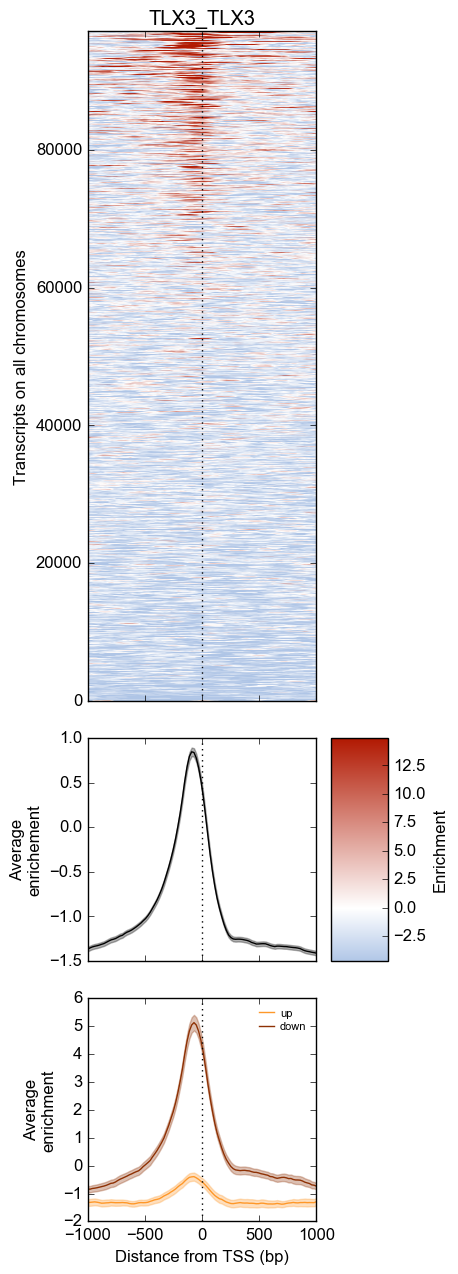

In [40]:
fig = metaseq.plotutils.imshow(
    # Same as before...
   arrays['tlx-bw'],
    x=x,
    figsize=(6, 14),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),
    sort_by=arrays['tlx-bw'].mean(axis=1),


    # Default was (3,1); here we add another number
    height_ratios=(3, 1, 1)
)

# `fig.gs` contains the `matplotlib.gridspec.GridSpec` object,
# so we can now create the new axes.
bottom_axes = plt.subplot(fig.gs[2, 0])
# Signal over TSSs of transcripts that were activated upon knockdown.
metaseq.plotutils.ci_plot(
    x,
    upregulated,
    line_kwargs=dict(color='#fe9829', label='up'),
    fill_kwargs=dict(color='#fe9829', alpha=0.3),
    ax=bottom_axes)

# Signal over TSSs of transcripts that were repressed upon knockdown
metaseq.plotutils.ci_plot(
    x,
    downregulated,
    line_kwargs=dict(color='#8e3104', label='down'),
    fill_kwargs=dict(color='#8e3104', alpha=0.3),
    ax=bottom_axes)

# Signal over TSSs tof transcripts that did not change upon knockdown
#metaseq.plotutils.ci_plot(
 #   x,
 #   unchanged,
 #   line_kwargs=dict(color='.5', label='unchanged'),
 #   fill_kwargs=dict(color='.5', alpha=0.3),
 #   ax=bottom_axes);
# Clean up redundant x tick labels, and add axes labels
fig.line_axes.set_xticklabels([])
fig.array_axes.set_xticklabels([])
fig.line_axes.set_ylabel('Average\nenrichement')
fig.array_axes.set_ylabel('Transcripts on all chromosomes')
bottom_axes.set_ylabel('Average\nenrichment')
bottom_axes.set_xlabel('Distance from TSS (bp)')
fig.cax.set_ylabel('Enrichment')
fig.array_axes.set_title("TLX3_TLX3")

# Add the vertical lines for TSS position to all axes
for ax in [fig.line_axes, fig.array_axes, bottom_axes]:
    ax.axvline(0, linestyle=':', color='k')

# Nice legend
bottom_axes.legend(loc='best', frameon=False, fontsize=8, labelspacing=.3, handletextpad=0.2)
fig.subplots_adjust(left=0.3, right=0.8, bottom=0.05)

# ngs.plot.r

In [40]:
# ngs.plot can also accept bam-pairs for plotting. A bam-pair is a pair of bam files separated 
# by colon, such as ChIP vs. Input.
print "ngs.plot.r -G mm9 -R tss -C " + tlx_bam + ":" + tlx_inp + " -O hesc.TLX3_TLX3vsInput.tss -T TLX3_TLX3 -L 3000"


ngs.plot.r -G mm9 -R tss -C /home/sergio/media/NAS4/PFlab/TLX3_project/ChiP-Seq/TLX3/04aln/TLX3_TLX3_merged.sorted.bam:/home/sergio/media/NAS4/PFlab/TLX3_project/ChiP-Seq/TLX3/04aln/control.sorted.bam -O hesc.TLX3_TLX3vsInput.tss -T TLX3_TLX3 -L 3000


In [41]:
# ngs.plot can also accept bam-pairs for plotting. A bam-pair is a pair of bam files separated 
# by colon, such as ChIP vs. Input.
print "ngs.plot.r -G mm9 -R tss -C " + rag_bam + ":" + rag_inp + " -O hesc.RAG_TLX3vsInput.tss -T RAG_TLX3 -L 3000"


ngs.plot.r -G mm9 -R tss -C /home/sergio/media/NAS4/PFlab/TLX3_project/ChiP-Seq/RAG_DN/04aln/RAG_TLX3_repl1.sorted.bam:/home/sergio/media/NAS4/PFlab/TLX3_project/ChiP-Seq/RAG_DN/04aln/INP-RAG_1.sorted.bam -O hesc.RAG_TLX3vsInput.tss -T RAG_TLX3 -L 3000


# K-means clustering of ChIP-seq signal

In [ ]:
# K-means input data should be normalized (mean=0, stddev=1)
from sklearn import preprocessing
tlx_scaled = preprocessing.scale(arrays['tlx-bw'])

# number of clasters
k = 6

ind, breaks = metaseq.plotutils.new_clustered_sortind(

    # The array to cluster
    tlx_scaled,

    # Within each cluster, how the rows should be sorted
    row_key=np.mean,

    # How each cluster should be sorted
    cluster_key=np.median,

    # Number of clusters
    k=k)

In [42]:
ind

array([72092, 72091, 72093, ..., 70436, 94367, 94339])

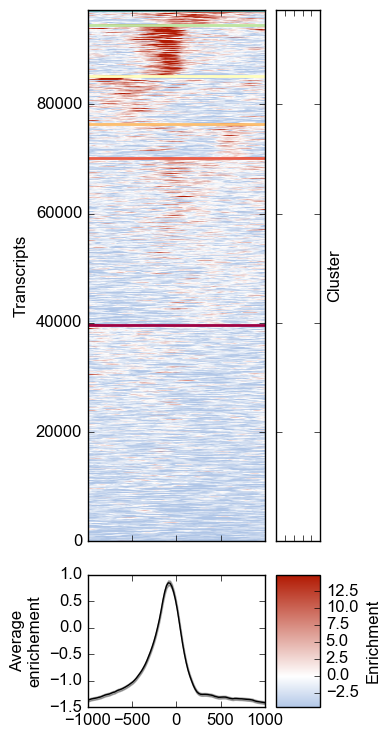

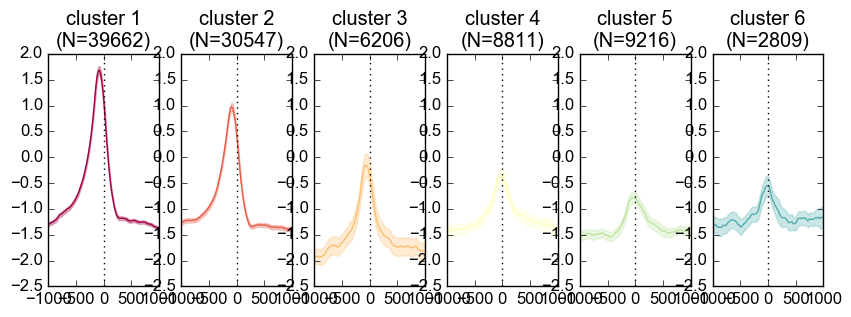

In [54]:
# Plot the heatmap again
fig = metaseq.plotutils.imshow(
    arrays['tlx-bw'],
    x=x,
    figsize=(3, 9),
    vmin=5, vmax=99,  percentile=True,
    line_kwargs=dict(color='k', label='All'),
    fill_kwargs=dict(color='k', alpha=0.3),

    # A little tricky: `sort_by` expects values to sort by
    # (say, expression values). But we've pre-calculated
    # our actual sort index based on clusters, so we transform
    # it like this
    sort_by=np.argsort(ind),

    # This adds a "strip" axes on the right side, useful
    # for adding extra information. We'll add cluster color
    # codes here.
    strip=True,
)

# De-clutter by hiding labels
plt.setp(
    fig.strip_axes.get_yticklabels()
    + fig.strip_axes.get_xticklabels()
    + fig.array_axes.get_xticklabels(),
    visible=False)

#
fig.line_axes.set_ylabel('Average\nenrichement')
fig.array_axes.set_ylabel('Transcripts')
fig.strip_axes.yaxis.set_label_position('right')
fig.strip_axes.set_ylabel('Cluster')
fig.cax.set_ylabel('Enrichment')

# Make colors
import matplotlib
cmap = matplotlib.cm.Spectral
colors = cmap(np.arange(k) / float(k))

# This figure will contain average signal for each cluster
fig2 = plt.figure(figsize=(10,3))


last_break = 0
cluster_number = 1
n_panel_rows = 1
n_panel_cols = k
for color, this_break in zip(colors, breaks):
    if cluster_number == 1:
        sharex = None
        sharey = None
    else:
        sharex = fig2.axes[0]
        sharey = fig2.axes[0]

    ax = fig2.add_subplot(
        n_panel_rows,
        n_panel_cols,
        cluster_number,
        sharex=sharex,
        sharey=sharey)

    # The y position is somewhat tricky: the array was
    # displayed using matplotlib.imshow with the argument
    # `origin="lower"`, which means the row in the plot at y=0
    # corresponds to the last row in the array (index=-1).
    # But the  breaks are in array coordinates. So we convert
    # them by subtracting from the total array size.
    xpos = 0
    width = 1
    ypos = this_break #len(arrays['tlx-bw']) - this_break
    height = this_break - last_break
    rect = matplotlib.patches.Rectangle(
        (xpos, ypos), width=width, height=height, color=color)
    #fig.strip_axes.add_patch(rect)
    fig.array_axes.axhline(ypos, color=color, linewidth=2)

    chunk =arrays['tlx-bw'][last_break:this_break]

    metaseq.plotutils.ci_plot(
        x,
        chunk,
        ax=ax,
        line_kwargs=dict(color=color),
        fill_kwargs=dict(color=color, alpha=0.3),
        )
    ax.axvline(0, color='k', linestyle=':')
    ax.set_title('cluster %s\n(N=%s)' % (cluster_number, len(chunk)))
    cluster_number += 1
    last_break = this_break

# Scatterplots of RNA-seq and ChIP-seq signal

In [44]:
# Convert to ResultsTable so we can take advantage of its
# `scatter` method
rt = ResultsTable(fc_data)

# Get the up/down regulated
up = rt.logFC > 1
dn = rt.logFC < -1
#up = rt.log2foldchange > 1
#dn = rt.log2foldchange < -1

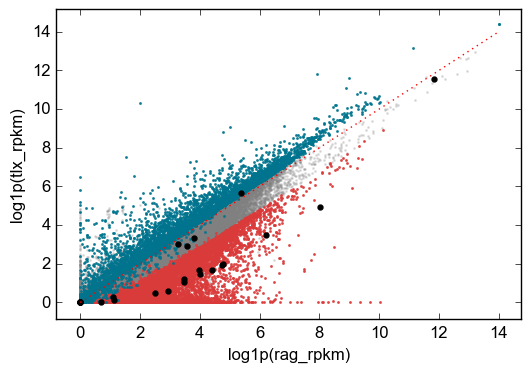

In [45]:
%config InlineBackend.figure_format = 'png'
# Go back to the ChIP-seq data and create a boolean array
# that is True only for the top TSSes with the strongest
# mean signal
tss_means = arrays['tlx-bw'].mean(axis=1)
strongest_signal = np.zeros(len(tss_means)) == 1
strongest_signal[np.argsort(tss_means)[-25:]] = True

#rt.scatter(
#    x='score_rag',
#    y='score_tlx',
#    xfunc=np.log1p,
#    yfunc=np.log1p,
#    genes_to_highlight=[
#        (up, dict(color='#da3b3a', alpha=0.8)),
#        (dn, dict(color='#00748e', alpha=0.8)),
#        (strongest_signal, dict(color='k', s=50, alpha=1)),
#
#    ],
#    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
#    one_to_one=dict(color='r', linestyle=':')
#);

rt.scatter(
    x='rag_rpkm',
    y='tlx_rpkm',
    xfunc=np.log1p,
    yfunc=np.log1p,
    genes_to_highlight=[
        (up, dict(color='#da3b3a', alpha=0.8)),
        (dn, dict(color='#00748e', alpha=0.8)),
        (strongest_signal, dict(color='k', s=50, alpha=1)),

    ],
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    one_to_one=dict(color='r', linestyle=':')
);

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:1295: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  positions.sort()
/usr/lib/python2.7/dist-packages/matplotlib/collections.py:1290: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  positions.sort()


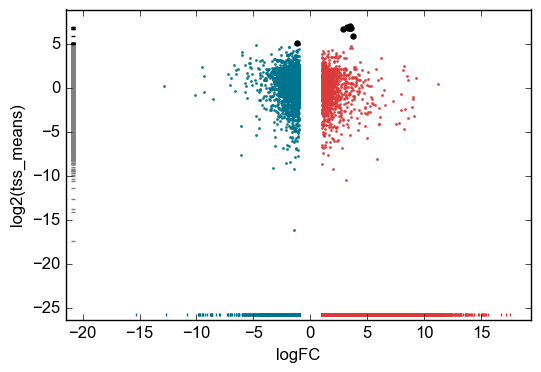

In [46]:
# Perhaps a better analysis would be to plot average
# ChIP-seq signal vs log2foldchange directly. In an imaginary
# world where biology is simple, we might expect TSSes with stronger
# log2foldchange upon knockdown to have stronger ChIP-seq signal
# in the control.
#
# To take advantage of the `scatter` method of ResultsTable objects,
# we simply add the TSS signal means as another variable in the
# dataframe. Then we can refer to it by name in `scatter`.
#
# We'll also use the same colors and genes to highlight from
# above.


#~ rag_vs_tlx_table.data['tss_means'] = tss_means
#~ rag_vs_tlx_table.scatter(
    #~ x='logFC',
    #~ y='tss_means',
    #~ genes_to_highlight=[
        #~ (up, dict(color='#da3b3a', alpha=0.8)),
        #~ (dn, dict(color='#00748e', alpha=0.8)),
        #~ (strongest_signal, dict(color='k', s=50, alpha=1)),
    #~ ],
    #~ general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    #~ yfunc=np.log2);


rt.data['tss_means'] = tss_means
rt.scatter(
    x='logFC',
    y='tss_means',
    genes_to_highlight=[
        (up, dict(color='#da3b3a', alpha=0.8)),
        (dn, dict(color='#00748e', alpha=0.8)),
        (strongest_signal, dict(color='k', s=50, alpha=1)),
    ],
    general_kwargs=dict(marker='.', color='0.5', alpha=0.2, s=5),
    yfunc=np.log2);

# Top 200 from ChiP-seq

In [47]:
sort_indices


array([94339, 94367, 70436, ..., 72092, 72106, 73260])

In [48]:
top200 = rt.data.iloc[sort_indices[:200]]


In [49]:
gene_names = pd.read_table("tracks/UCSC_mm9_transcripID_to_geneSymbol.sort.txt", index_col=0,names=["Geneid", "Gene_name"])

In [50]:
gene_names.head()

,Gene_name
Geneid,
ENSMUST00000000001,Gnai3
ENSMUST00000000003,Pbsn
ENSMUST00000000010,Hoxb9
ENSMUST00000000028,Cdc45
ENSMUST00000000033,Igf2


In [51]:
top200names = gene_names.loc[top200.index]

In [52]:
top200all = top200names.join(top200)

In [53]:
top200all[["Gene_name","tss_means","RAG","TLX3","log2foldchange","logFC"]].head(40)

,Gene_name,tss_means,RAG,TLX3,log2foldchange,logFC
Geneid,,,,,,
ENSMUST00000151376,Gm10722,132.940308,808,54,4.238842,3.521131
ENSMUST00000170073,Gm17535,127.501429,14,3,2.557911,NaN
ENSMUST00000099056,Gm10106,126.178221,80,6,4.072484,NaN
ENSMUST00000143083,Gm16869,125.403705,6162,490,3.988063,3.402465
ENSMUST00000075573,Gm10717,118.643499,390,31,3.988652,3.256227
ENSMUST00000099050,Gm10720,117.931741,818,55,4.230115,3.524671
ENSMUST00000099049,Gm10719,116.432812,7,0,inf,NaN
ENSMUST00000099047,Gm11167,114.081508,583,40,4.200942,3.486094
ENSMUST00000099051,Gm10721,113.360348,355,38,3.559266,3.295323
